In [193]:
import pandas as pd
from IPython.display import display, HTML
from assembly_tools import format_table, extract_raw_performance
from hydra import initialize, compose
import numpy as np

### Assembly of experimental results 1

In [181]:
# We conduced a large HP search to determine which HP configurations are optimal for a certain method and dataset. 
# You can un the same HP searches by using the benchmarking script in the causal discovery zoo folder. 
# Check the readme for details. You can also reproduce the actual numbers by running the selected HP combo in the same way.
# YOu can also use the functions here directly to summarize your own custom hp searches.
# NOTABLY THE EXACT HP NAMING was changed slightly due to changes in the slurm configurations. the exported params however can be directly used.

In [182]:
with initialize(version_base=None, config_path="config/"):
    cfg = compose(config_name='extract.yaml')
scoring = "Individual AUROC"
general_params =  ["resolution_value", "ds_name", "method_hps.max_lag"]
hp_stack = []
performance_stack = []

In [183]:
for name in ["reverse", "cross", "combo", ]:
    data = pd.read_csv("grid_export_exp1/" + name + ".csv", index_col=0)
    # quick fix
    res = "method.filter_mode"

    data.loc[data[res].isnull(),res] = "none"
    formatted = format_table(data,cfg, scoring= scoring, restriction=[res] if res else [])
    lines = extract_raw_performance(formatted,cfg,scoring,name=name, restriction=[res])
    hp_stack.append(formatted)
    performance_stack.append(lines)


In [184]:
for name in ["var_", "varlingam", "dynotears", "pcmci"]:
    data = pd.read_csv("grid_export_exp1/" + name + ".csv", index_col=0)
    # quick fix
    res = None
    formatted = format_table(data,cfg, scoring= scoring, restriction=[res] if res else [])
    lines = extract_raw_performance(formatted,cfg,scoring,name=name, restriction=None)
    hp_stack.append(formatted)
    performance_stack.append(lines)

In [185]:
bs = data[["Null AUROC", "label_path"]].groupby("label_path").max().T
bs.index = ["Null model"]

In [186]:
# load this seperately as we ran this completely seperated.
#data = load_experimental_grid(mypath=cfg.data_path + "exp1/", method_name="cdmi").T
# data.to_csv(cfg.data_path + "exp1/cached.csv")
data = pd.read_csv(cfg.data_path + "exp1/cached.csv", index_col=0)
for x in cfg.rename:
    if x in data.columns:
        print("renaming..", x)
        if cfg.rename[x] in data.columns:
            data.loc[data[cfg.rename[x]].isnull(), cfg.rename[x]] = data.loc[
                data[cfg.rename[x]].isnull(), x
            ]
            data.drop(columns=x, inplace=True)
        else:
            data.rename(columns={x: cfg.rename[x]}, inplace=True)
data = data[[scoring, "label_path"]].groupby("label_path").mean()
data = data.rename(index= {"../../datasets/close_3/east.p": "close_3","../../datasets/close_5/east.p":"close_5"}).loc[cfg.ds_order].T
data.index.name = None
data.index = ["CDMI"]
performance_stack.append(data)

renaming.. resolution_value
renaming.. method_hps.max_lag
renaming.. method_hps.cp_architecture
renaming.. ds_name
renaming.. normalize
renaming.. window_data_month_value
renaming.. window_data_year_value


/tmp/ipykernel_3520831/2672914234.py:4: DtypeWarning: Columns (22,24,25,30,54,55,58,59,61,62,63,64,66,67,75,76,77,81,82,85,86,87,88,89,90,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(cfg.data_path + "exp1/cached.csv", index_col=0)


In [187]:
for name in ["cp"]:
    data = pd.read_csv("grid_export_exp1/" + name + ".csv", index_col=0)
    # quick fix
    res = "method.architecture"
    cfg.ds_order = cfg.ds_order[:-1]
    formatted = format_table(data,cfg, scoring= scoring, restriction=[res] if res else [])
    lines = extract_raw_performance(formatted,cfg,scoring,name=name, restriction=[res])
    hp_stack.append(formatted)
    performance_stack.append(lines)


In [188]:
performance_stack.append(bs)
out = pd.concat(performance_stack)

In [189]:
out

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
reverse_biggest,0.775306,0.708554,0.609271,0.528232,0.805991,0.714176,0.605903,0.624542,0.756933,0.683675,0.577119
reverse_none,0.797792,0.761499,0.761107,0.700442,0.737327,0.733954,0.623264,0.65985,0.79313,0.753329,0.748214
reverse_next,0.71744,0.623394,0.813367,0.766431,0.713825,0.65058,0.578125,0.583365,0.722826,0.641822,0.651639
cross_none,0.684317,0.627601,0.70416,0.668861,0.643472,0.65871,0.651042,0.59354,0.709448,0.706202,0.661196
cross_corr,0.689555,0.641539,0.719954,0.703476,0.692473,0.670497,0.635417,0.600899,0.706208,0.671744,0.753657
combo_corr,0.705432,0.656692,0.705958,0.679399,0.71321,0.674332,0.652778,0.610375,0.713873,0.672164,0.754721
combo_next,0.676741,0.597341,0.731446,0.703865,0.670507,0.639665,0.618056,0.572187,0.692168,0.643728,0.659784
combo_biggest,0.678111,0.631308,0.597329,0.545798,0.71659,0.657362,0.631944,0.583483,0.689834,0.650093,0.572621
combo_none,0.704707,0.657373,0.695942,0.649975,0.677573,0.681069,0.631944,0.600877,0.72098,0.712596,0.705569
var_,0.809397,0.806224,0.787879,0.750714,0.8,0.793418,0.708912,0.722216,0.82323,0.801485,0.819753


# Styling of the table

In [190]:
out = out.loc[out.index[[16,1,2,0,3,4,8,6,7,5,9,10,11,12,13,14,15]]]

In [191]:
out.rename(index={
"cross_none": "CC",
"cross_corr": "CC+C",
"reverse_none": "RP",
"reverse_biggest": "RP+B",
"reverse_next": "RP+N",
"combo_none": "RPCC",
"combo_biggest": "RPCC+B",
"combo_next": "RPCC+N",
"combo_corr": "RPCC+C",
"cp__unidirectional": "CP (Gru)",
"cp__transformer":"CP (Transf)",
"var_": "VAR",
"varlingam": "Varlingam",
"pcmci": "PCMCI"
}, inplace=True)

In [245]:
out

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
RP,0.797792,0.761499,0.761107,0.700442,0.737327,0.733954,0.623264,0.65985,0.79313,0.753329,0.748214
RP+N,0.71744,0.623394,0.813367,0.766431,0.713825,0.65058,0.578125,0.583365,0.722826,0.641822,0.651639
RP+B,0.775306,0.708554,0.609271,0.528232,0.805991,0.714176,0.605903,0.624542,0.756933,0.683675,0.577119
CC,0.684317,0.627601,0.70416,0.668861,0.643472,0.65871,0.651042,0.59354,0.709448,0.706202,0.661196
CC+C,0.689555,0.641539,0.719954,0.703476,0.692473,0.670497,0.635417,0.600899,0.706208,0.671744,0.753657
RPCC,0.704707,0.657373,0.695942,0.649975,0.677573,0.681069,0.631944,0.600877,0.72098,0.712596,0.705569
RPCC+N,0.676741,0.597341,0.731446,0.703865,0.670507,0.639665,0.618056,0.572187,0.692168,0.643728,0.659784
RPCC+B,0.678111,0.631308,0.597329,0.545798,0.71659,0.657362,0.631944,0.583483,0.689834,0.650093,0.572621
RPCC+C,0.705432,0.656692,0.705958,0.679399,0.71321,0.674332,0.652778,0.610375,0.713873,0.672164,0.754721


In [277]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

In [324]:
# Choose colormap which will be mixed with the alpha values
cmap = pl.cm.Blues_r

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))
# Define the alphas in the range from 0 to 1
alphas = np.linspace(0, 1, cmap.N)
# Define the background as white
BG = np.asarray([1., 1., 1.,])
# Mix the colors with the background
for i in range(cmap.N):
    my_cmap[i,:-1] = my_cmap[i,:-1] * alphas[i] + BG * (1.-alphas[i])
# Create new colormap which mimics the alpha values
my_cmap = ListedColormap(my_cmap)

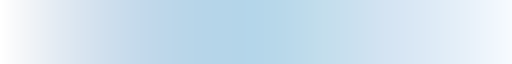

In [325]:
my_cmap

In [352]:
table = out.rank(ascending=True).style.background_gradient(cmap="YlGn_r", axis="index", vmin=0.4)
table.data = out
table.format(precision=2)

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
RP,0.80,0.76,0.76,0.70,0.74,0.73,0.62,0.66,0.79,0.75,0.75
RP+N,0.72,0.62,0.81,0.77,0.71,0.65,0.58,0.58,0.72,0.64,0.65
RP+B,0.78,0.71,0.61,0.53,0.81,0.71,0.61,0.62,0.76,0.68,0.58
CC,0.68,0.63,0.70,0.67,0.64,0.66,0.65,0.59,0.71,0.71,0.66
CC+C,0.69,0.64,0.72,0.70,0.69,0.67,0.64,0.60,0.71,0.67,0.75
RPCC,0.70,0.66,0.70,0.65,0.68,0.68,0.63,0.60,0.72,0.71,0.71
RPCC+N,0.68,0.60,0.73,0.70,0.67,0.64,0.62,0.57,0.69,0.64,0.66
RPCC+B,0.68,0.63,0.60,0.55,0.72,0.66,0.63,0.58,0.69,0.65,0.57
RPCC+C,0.71,0.66,0.71,0.68,0.71,0.67,0.65,0.61,0.71,0.67,0.75


In [353]:
table = out.rank(ascending=True).style.background_gradient(cmap="Blues_r", axis="index", vmin=0.4)
table.data = out
table.format(precision=2)

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
RP,0.80,0.76,0.76,0.70,0.74,0.73,0.62,0.66,0.79,0.75,0.75
RP+N,0.72,0.62,0.81,0.77,0.71,0.65,0.58,0.58,0.72,0.64,0.65
RP+B,0.78,0.71,0.61,0.53,0.81,0.71,0.61,0.62,0.76,0.68,0.58
CC,0.68,0.63,0.70,0.67,0.64,0.66,0.65,0.59,0.71,0.71,0.66
CC+C,0.69,0.64,0.72,0.70,0.69,0.67,0.64,0.60,0.71,0.67,0.75
RPCC,0.70,0.66,0.70,0.65,0.68,0.68,0.63,0.60,0.72,0.71,0.71
RPCC+N,0.68,0.60,0.73,0.70,0.67,0.64,0.62,0.57,0.69,0.64,0.66
RPCC+B,0.68,0.63,0.60,0.55,0.72,0.66,0.63,0.58,0.69,0.65,0.57
RPCC+C,0.71,0.66,0.71,0.68,0.71,0.67,0.65,0.61,0.71,0.67,0.75


In [360]:
table = out.rank(ascending=True).style.background_gradient(cmap="PuBu_r", axis="index", vmin=0.45)
table.data = out
table.format(precision=2)

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
RP,0.80,0.76,0.76,0.70,0.74,0.73,0.62,0.66,0.79,0.75,0.75
RP+N,0.72,0.62,0.81,0.77,0.71,0.65,0.58,0.58,0.72,0.64,0.65
RP+B,0.78,0.71,0.61,0.53,0.81,0.71,0.61,0.62,0.76,0.68,0.58
CC,0.68,0.63,0.70,0.67,0.64,0.66,0.65,0.59,0.71,0.71,0.66
CC+C,0.69,0.64,0.72,0.70,0.69,0.67,0.64,0.60,0.71,0.67,0.75
RPCC,0.70,0.66,0.70,0.65,0.68,0.68,0.63,0.60,0.72,0.71,0.71
RPCC+N,0.68,0.60,0.73,0.70,0.67,0.64,0.62,0.57,0.69,0.64,0.66
RPCC+B,0.68,0.63,0.60,0.55,0.72,0.66,0.63,0.58,0.69,0.65,0.57
RPCC+C,0.71,0.66,0.71,0.68,0.71,0.67,0.65,0.61,0.71,0.67,0.75


In [372]:
table = out.rank(ascending=True).style.background_gradient(cmap="BuGn_r", axis="index", vmin=0.4)
table.data = out
table.format(precision=2)

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
RP,0.80,0.76,0.76,0.70,0.74,0.73,0.62,0.66,0.79,0.75,0.75
RP+N,0.72,0.62,0.81,0.77,0.71,0.65,0.58,0.58,0.72,0.64,0.65
RP+B,0.78,0.71,0.61,0.53,0.81,0.71,0.61,0.62,0.76,0.68,0.58
CC,0.68,0.63,0.70,0.67,0.64,0.66,0.65,0.59,0.71,0.71,0.66
CC+C,0.69,0.64,0.72,0.70,0.69,0.67,0.64,0.60,0.71,0.67,0.75
RPCC,0.70,0.66,0.70,0.65,0.68,0.68,0.63,0.60,0.72,0.71,0.71
RPCC+N,0.68,0.60,0.73,0.70,0.67,0.64,0.62,0.57,0.69,0.64,0.66
RPCC+B,0.68,0.63,0.60,0.55,0.72,0.66,0.63,0.58,0.69,0.65,0.57
RPCC+C,0.71,0.66,0.71,0.68,0.71,0.67,0.65,0.61,0.71,0.67,0.75


In [370]:
table = out.rank(ascending=True).style.background_gradient(cmap="BuGn_r", axis="index")
table.data = out
table.format(precision=2)

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
RP,0.80,0.76,0.76,0.70,0.74,0.73,0.62,0.66,0.79,0.75,0.75
RP+N,0.72,0.62,0.81,0.77,0.71,0.65,0.58,0.58,0.72,0.64,0.65
RP+B,0.78,0.71,0.61,0.53,0.81,0.71,0.61,0.62,0.76,0.68,0.58
CC,0.68,0.63,0.70,0.67,0.64,0.66,0.65,0.59,0.71,0.71,0.66
CC+C,0.69,0.64,0.72,0.70,0.69,0.67,0.64,0.60,0.71,0.67,0.75
RPCC,0.70,0.66,0.70,0.65,0.68,0.68,0.63,0.60,0.72,0.71,0.71
RPCC+N,0.68,0.60,0.73,0.70,0.67,0.64,0.62,0.57,0.69,0.64,0.66
RPCC+B,0.68,0.63,0.60,0.55,0.72,0.66,0.63,0.58,0.69,0.65,0.57
RPCC+C,0.71,0.66,0.71,0.68,0.71,0.67,0.65,0.61,0.71,0.67,0.75


In [209]:
print(table.to_latex())

\begin{tabular}{llllllllllll}
 & close_3 & close_5 & root_cause_3 & root_cause_5 & 1_random_3 & 1_random_5 & confounder_3 & confounder_5 & random_3 & random_5 & disjoint_10 \\
Null model & \background-color#004529 \color#f1f1f1 0.50 & \background-color#004529 \color#f1f1f1 0.50 & \background-color#004529 \color#f1f1f1 0.50 & \background-color#004529 \color#f1f1f1 0.50 & \background-color#004529 \color#f1f1f1 0.50 & \background-color#004529 \color#f1f1f1 0.50 & \background-color#004529 \color#f1f1f1 0.50 & \background-color#004529 \color#f1f1f1 0.50 & \background-color#004529 \color#f1f1f1 0.50 & \background-color#004529 \color#f1f1f1 0.50 & \background-color#004529 \color#f1f1f1 0.50 \\
RP & \background-color#fdfed9 \color#000000 0.80 & \background-color#edf8b2 \color#000000 0.76 & \background-color#edf8b2 \color#000000 0.76 & \background-color#d7efa2 \color#000000 0.70 & \background-color#c7e89a \color#000000 0.74 & \background-color#dff3a8 \color#000000 0.73 & \background-color#9fd78

In [166]:
out.style.set_precision(2).background_gradient(axis=0, cmap="inferno")

AttributeError: 'Styler' object has no attribute 'set_precision'

In [158]:
out.rank(ascending=False).astype(float).style.background_gradient(axis=0, cmap="inferno")

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,16.500000,16.500000,16.500000,17.000000,17.000000,17.000000,17.000000,17.000000,16.500000,17.000000,15.000000
RP,3.000000,4.000000,4.000000,6.000000,8.000000,5.000000,10.500000,4.000000,3.500000,3.500000,5.500000
RP+N,6.000000,12.500000,1.000000,1.500000,10.500000,13.500000,13.000000,11.500000,6.500000,13.500000,11.000000
RP+B,5.000000,5.000000,14.000000,16.000000,4.500000,7.000000,12.000000,6.000000,5.000000,7.000000,13.000000
CC,11.000000,10.500000,10.000000,10.000000,15.000000,11.500000,4.500000,10.000000,9.000000,5.500000,9.500000
CC+C,9.000000,9.000000,6.500000,6.000000,12.000000,9.500000,6.000000,8.500000,9.000000,8.500000,5.500000
RPCC,8.000000,6.500000,10.000000,11.500000,13.000000,8.000000,8.000000,8.500000,6.500000,5.500000,8.000000
RPCC+N,11.000000,14.000000,5.000000,6.000000,14.000000,15.000000,10.500000,13.000000,11.500000,13.500000,9.500000
RPCC+B,11.000000,10.500000,15.000000,15.000000,9.000000,11.500000,8.000000,11.500000,11.500000,11.000000,14.000000
RPCC+C,7.000000,6.500000,8.000000,8.500000,10.500000,9.500000,4.500000,7.000000,9.000000,8.500000,5.500000


In [152]:
out.rank(ascending=False).astype(int).style.background_gradient(axis=0, cmap="inferno")

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [104]:
out.style.apply(lambda x: ranking.applymap(color_cells), axis=None)

/tmp/ipykernel_3520831/2309124490.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  out.style.apply(lambda x: ranking.applymap(color_cells), axis=None)


TypeError: Function <function <lambda> at 0x7b9659372f20> must return a DataFrame or ndarray when passed to `Styler.apply` with axis=None

In [99]:
out.rank().style.background_gradient(axis=0)

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
RP,15.000000,14.000000,14.000000,11.000000,10.000000,13.000000,8.000000,14.000000,15.000000,14.000000,9.000000
RP+N,12.000000,6.000000,17.000000,16.000000,8.000000,5.000000,5.000000,6.000000,12.000000,4.000000,5.000000
RP+B,13.000000,13.000000,4.000000,2.000000,13.000000,11.000000,6.000000,12.000000,13.000000,11.000000,3.000000
CC,8.000000,7.000000,9.000000,8.000000,3.000000,7.000000,13.000000,8.000000,9.000000,12.000000,7.000000
CC+C,9.000000,9.000000,12.000000,12.000000,6.000000,8.000000,12.000000,10.000000,8.000000,9.000000,11.000000
RPCC,10.000000,12.000000,8.000000,7.000000,5.000000,10.000000,10.000000,9.000000,11.000000,13.000000,8.000000
RPCC+N,6.000000,4.000000,13.000000,13.000000,4.000000,3.000000,7.000000,5.000000,7.000000,5.000000,6.000000
RPCC+B,7.000000,8.000000,3.000000,3.000000,9.000000,6.000000,10.000000,7.000000,6.000000,6.000000,2.000000
RPCC+C,11.000000,11.000000,10.000000,9.000000,7.000000,9.000000,14.000000,11.000000,10.000000,10.000000,12.000000


In [91]:
out.loc[out.index[out["close_3"].argsort().values]]

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
dynotears,0.500967,0.49934,0.502696,0.563879,0.519201,0.608279,0.525174,0.531982,0.502979,0.608445,0.606428
cp_transformer,0.60375,0.651986,0.615263,0.679577,0.804301,0.715191,0.559028,0.564034,0.601687,0.651431,NaN
PCMCI,0.638681,0.616857,0.695793,0.736581,0.830876,0.73502,0.662616,0.639717,0.654862,0.652921,0.801787
cp_unidirectional,0.658231,0.576534,0.67955,0.558017,0.807988,0.647456,0.5625,0.562134,0.643731,0.598753,NaN
RPCC+N,0.676741,0.597341,0.731446,0.703865,0.670507,0.639665,0.618056,0.572187,0.692168,0.643728,0.659784
RPCC+B,0.678111,0.631308,0.597329,0.545798,0.71659,0.657362,0.631944,0.583483,0.689834,0.650093,0.572621
CC,0.684317,0.627601,0.70416,0.668861,0.643472,0.65871,0.651042,0.59354,0.709448,0.706202,0.661196
CC+C,0.689555,0.641539,0.719954,0.703476,0.692473,0.670497,0.635417,0.600899,0.706208,0.671744,0.753657
RPCC,0.704707,0.657373,0.695942,0.649975,0.677573,0.681069,0.631944,0.600877,0.72098,0.712596,0.705569


In [82]:
pd.concat([out[x].argsort() for x in out.columns],axis=1).style.background_gradient(axis=0)

/tmp/ipykernel_3520831/3563899727.py:1: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  pd.concat([out[x].argsort() for x in out.columns],axis=1).style.background_gradient(axis=0)


,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0,12,0,0,0,0,0,0,0,0,0
RP,12,0,12,3,12,12,12,12,12,16,8
RP+N,15,16,8,8,4,7,15,16,15,12,3
RP+B,13,7,3,16,7,16,16,15,16,2,12
CC,16,13,15,12,6,2,2,7,13,7,2
CC+C,7,2,16,14,5,8,3,2,8,8,7
RPCC,8,4,13,6,9,4,7,8,7,15,4
RPCC+N,4,8,6,4,2,5,1,4,5,13,6
RPCC+B,5,5,4,9,8,9,8,6,4,5,1
RPCC+C,6,15,9,15,1,6,6,5,9,9,14


In [74]:
out.argsort()

AttributeError: 'DataFrame' object has no attribute 'argsort'

In [73]:
out.iloc[np.argsort(out["close_3"]).values]

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
dynotears,0.500967,0.49934,0.502696,0.563879,0.519201,0.608279,0.525174,0.531982,0.502979,0.608445,0.606428
cp_transformer,0.60375,0.651986,0.615263,0.679577,0.804301,0.715191,0.559028,0.564034,0.601687,0.651431,NaN
PCMCI,0.638681,0.616857,0.695793,0.736581,0.830876,0.73502,0.662616,0.639717,0.654862,0.652921,0.801787
cp_unidirectional,0.658231,0.576534,0.67955,0.558017,0.807988,0.647456,0.5625,0.562134,0.643731,0.598753,NaN
RPCC+N,0.676741,0.597341,0.731446,0.703865,0.670507,0.639665,0.618056,0.572187,0.692168,0.643728,0.659784
RPCC+B,0.678111,0.631308,0.597329,0.545798,0.71659,0.657362,0.631944,0.583483,0.689834,0.650093,0.572621
CC,0.684317,0.627601,0.70416,0.668861,0.643472,0.65871,0.651042,0.59354,0.709448,0.706202,0.661196
CC+C,0.689555,0.641539,0.719954,0.703476,0.692473,0.670497,0.635417,0.600899,0.706208,0.671744,0.753657
RPCC,0.704707,0.657373,0.695942,0.649975,0.677573,0.681069,0.631944,0.600877,0.72098,0.712596,0.705569


In [58]:
out["close_3"].argsort()

Null model            0
RP                   12
RP+N                 15
RP+B                 13
CC                   16
CC+C                  7
RPCC                  8
RPCC+N                4
RPCC+B                5
RPCC+C                6
VAR                   9
Varlingam             2
dynotears             3
PCMCI                11
CDMI                  1
cp_transformer       14
cp_unidirectional    10
Name: close_3, dtype: int64

In [54]:
out.apply(pd.to_numeric).style.background_gradient(axis=0)

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
RP,0.797792,0.761499,0.761107,0.700442,0.737327,0.733954,0.623264,0.659850,0.793130,0.753329,0.748214
RP+N,0.717440,0.623394,0.813367,0.766431,0.713825,0.650580,0.578125,0.583365,0.722826,0.641822,0.651639
RP+B,0.775306,0.708554,0.609271,0.528232,0.805991,0.714176,0.605903,0.624542,0.756933,0.683675,0.577119
CC,0.684317,0.627601,0.704160,0.668861,0.643472,0.658710,0.651042,0.593540,0.709448,0.706202,0.661196
CC+C,0.689555,0.641539,0.719954,0.703476,0.692473,0.670497,0.635417,0.600899,0.706208,0.671744,0.753657
RPCC,0.704707,0.657373,0.695942,0.649975,0.677573,0.681069,0.631944,0.600877,0.720980,0.712596,0.705569
RPCC+N,0.676741,0.597341,0.731446,0.703865,0.670507,0.639665,0.618056,0.572187,0.692168,0.643728,0.659784
RPCC+B,0.678111,0.631308,0.597329,0.545798,0.716590,0.657362,0.631944,0.583483,0.689834,0.650093,0.572621
RPCC+C,0.705432,0.656692,0.705958,0.679399,0.713210,0.674332,0.652778,0.610375,0.713873,0.672164,0.754721


In [52]:
display(HTML(style.to_html()))

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
RP,0.797792,0.761499,0.761107,0.700442,0.737327,0.733954,0.623264,0.659850,0.793130,0.753329,0.748214
RP+N,0.717440,0.623394,0.813367,0.766431,0.713825,0.650580,0.578125,0.583365,0.722826,0.641822,0.651639
RP+B,0.775306,0.708554,0.609271,0.528232,0.805991,0.714176,0.605903,0.624542,0.756933,0.683675,0.577119
CC,0.684317,0.627601,0.704160,0.668861,0.643472,0.658710,0.651042,0.593540,0.709448,0.706202,0.661196
CC+C,0.689555,0.641539,0.719954,0.703476,0.692473,0.670497,0.635417,0.600899,0.706208,0.671744,0.753657
RPCC,0.704707,0.657373,0.695942,0.649975,0.677573,0.681069,0.631944,0.600877,0.720980,0.712596,0.705569
RPCC+N,0.676741,0.597341,0.731446,0.703865,0.670507,0.639665,0.618056,0.572187,0.692168,0.643728,0.659784
RPCC+B,0.678111,0.631308,0.597329,0.545798,0.716590,0.657362,0.631944,0.583483,0.689834,0.650093,0.572621
RPCC+C,0.705432,0.656692,0.705958,0.679399,0.713210,0.674332,0.652778,0.610375,0.713873,0.672164,0.754721


In [263]:
style = out.style.background_gradient(cmap="Greens_r",low=0,high=1)
style = style.format("{:.2f}")
latex_str = style.to_latex(convert_css=True)
display(HTML(style.to_html()))

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,nan
RP,0.80,0.76,0.76,0.70,0.74,0.73,0.62,0.66,0.79,0.75,0.75
RP+N,0.72,0.62,0.81,0.77,0.71,0.65,0.58,0.58,0.72,0.64,0.65
RP+B,0.78,0.71,0.61,0.53,0.81,0.71,0.61,0.62,0.76,0.68,0.58
CC,0.68,0.63,0.70,0.67,0.64,0.66,0.65,0.59,0.71,0.71,0.66
CC+C,0.69,0.64,0.72,0.70,0.69,0.67,0.64,0.60,0.71,0.67,0.75
RPCC,0.70,0.66,0.70,0.65,0.68,0.68,0.63,0.60,0.72,0.71,0.71
RPCC+N,0.68,0.60,0.73,0.70,0.67,0.64,0.62,0.57,0.69,0.64,0.66
RPCC+B,0.68,0.63,0.60,0.55,0.72,0.66,0.63,0.58,0.69,0.65,0.57
RPCC+C,0.71,0.66,0.71,0.68,0.71,0.67,0.65,0.61,0.71,0.67,0.75


In [264]:
style

,close_3,close_5,root_cause_3,root_cause_5,1_random_3,1_random_5,confounder_3,confounder_5,random_3,random_5,disjoint_10
Null model,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,nan
RP,0.80,0.76,0.76,0.70,0.74,0.73,0.62,0.66,0.79,0.75,0.75
RP+N,0.72,0.62,0.81,0.77,0.71,0.65,0.58,0.58,0.72,0.64,0.65
RP+B,0.78,0.71,0.61,0.53,0.81,0.71,0.61,0.62,0.76,0.68,0.58
CC,0.68,0.63,0.70,0.67,0.64,0.66,0.65,0.59,0.71,0.71,0.66
CC+C,0.69,0.64,0.72,0.70,0.69,0.67,0.64,0.60,0.71,0.67,0.75
RPCC,0.70,0.66,0.70,0.65,0.68,0.68,0.63,0.60,0.72,0.71,0.71
RPCC+N,0.68,0.60,0.73,0.70,0.67,0.64,0.62,0.57,0.69,0.64,0.66
RPCC+B,0.68,0.63,0.60,0.55,0.72,0.66,0.63,0.58,0.69,0.65,0.57
RPCC+C,0.71,0.66,0.71,0.68,0.71,0.67,0.65,0.61,0.71,0.67,0.75


In [18]:
print(latex_str)

\begin{tabular}{llllllllllll}
 & close_3 & close_5 & root_cause_3 & root_cause_5 & 1_random_3 & 1_random_5 & confounder_3 & confounder_5 & random_3 & random_5 & disjoint_10 \\
VAR & 0.82 & 0.68 & 0.80 & 0.62 & 0.77 & 0.60 & 0.77 & 0.60 & 0.83 & 0.65 & 0.48 \\
RP+B & 0.73 & 0.57 & 0.50 & 0.33 & 0.61 & 0.50 & 0.56 & 0.47 & 0.71 & 0.53 & 0.24 \\
RP & 0.75 & 0.53 & 0.71 & 0.48 & 0.48 & 0.42 & 0.66 & 0.48 & 0.74 & 0.52 & 0.29 \\
RP+N & 0.68 & 0.46 & 0.86 & 0.67 & 0.55 & 0.43 & 0.55 & 0.45 & 0.69 & 0.49 & 0.36 \\
\end{tabular}

